In [1]:
import numpy as np
import pandas as pd
import utils
from sklearn.decomposition import PCA

# To make pretty plots
import matplotlib.pyplot as plt
import seaborn as sns

import stat_testing as stats

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%matplotlib inline

# Load data and select complete cases

In [2]:
df = pd.read_csv("../data/mimic-ft98-S0-train.csv")
print(df.shape)
df.head()

(10121, 105)


,stay_id,starttime,endtime,admission_location,insurance,language,ethnicity,marital_status,gender,age,...,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score,duration,log_duration,over72h,alive96h
0,38910812,2136-12-28 14:40:00,2136-12-31 17:42:00,EMERGENCY ROOM,Other,ENGLISH,UNKNOWN,SINGLE,M,56,...,2.0,0.0,8.0,0.0,6.0,48.0,75.033333,4.317932,1,0
1,38388229,2189-08-24 19:06:00,2189-09-02 16:44:00,EMERGENCY ROOM,Other,ENGLISH,BLACK/AFRICAN AMERICAN,MARRIED,M,81,...,0.0,0.0,0.0,3.0,3.0,33.0,213.633333,5.364261,1,1
2,31753166,2143-06-10 21:40:00,2143-06-14 16:05:00,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,WHITE,MARRIED,M,91,...,0.0,NaN,NaN,0.0,2.0,24.0,90.416667,4.504429,1,1
3,30003299,2169-08-22 01:51:00,2169-08-28 12:02:00,EMERGENCY ROOM,Other,ENGLISH,WHITE,SINGLE,M,26,...,0.0,NaN,NaN,0.0,12.0,15.0,154.183333,5.038142,1,1
4,31166711,2160-01-29 00:00:00,2160-02-15 12:17:00,EMERGENCY ROOM,Other,ENGLISH,WHITE,SINGLE,M,42,...,2.0,11.0,5.0,0.0,12.0,3.0,420.283333,6.040929,1,1


In [3]:
severity_scores = [ 'SOFA', 'respiration', 'coagulation', 'liver', 'cardiovascular', 'renal', 'cns',
                    'apsiii', 'hr_score', 'mbp_score', 'temp_score', 'resp_rate_score', 
                    'pao2_aado2_score', 'hematocrit_score','wbc_score', 'creatinine_score', 
                    'uo_score', 'bun_score', 'sodium_score', 'albumin_score', 
                    'bilirubin_score', 'glucose_score', 'acidbase_score', 'gcs_score']
len(severity_scores)

24

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)

corr = df[severity_scores].corr()
mask = np.zeros_like(corr)
mask[corr < 0.69] = True
sns.heatmap(corr, mask=mask,
            vmin=-1, vmax=1, cmap="RdBu_r", annot=True);
plt.title("MIMIC-IV");
plt.savefig('../results/severity scores corr MIMIC.jpeg', bbox_inches='tight', dpi=300)

**Complete cases only**

In [4]:
df_ = df.dropna(axis=0, how="any", subset=severity_scores)
df_.reset_index(drop=True, inplace=True)
df_.shape

(2557, 105)

# t-SNE

In [ ]:
from sklearn.manifold import TSNE

X = df[severity_scores]

tsne = TSNE(n_components=2)

X_embedded = tsne.fit_transform(X)

df[["tsne1", "tsne2"]] = X_embedded

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.scatterplot(x="tsne1", y="tsne2", data=df, hue="over72h");
plt.xlabel("t-SNE 1");
plt.ylabel("t-SNE 2");
plt.title("MIMIC-IV");

plt.savefig('../results/tSNE MIMIC.jpeg', bbox_inches='tight', dpi=300)

# Fit PCA to MIMIC data using the full feature set

In [ ]:
features = None
X, _ = utils.get_X_and_y(df_, features=None, label="log_duration")
features = X.columns

preprocessor = utils.define_preprocessor(features, scale=False)
X = preprocessor.fit_transform(df_[features])

In [ ]:
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
df = pd.concat([df, pd.DataFrame(X_pca, columns=["pc1", "pc2", "pc3"])], axis=1)

In [ ]:
df[df.pc1 > -700].duration.max()

In [ ]:
df["cluster"] = 0
df.loc[df.pc1 > -700, "cluster"] = 1

In [ ]:
sns.scatterplot(x="pc2", y="duration", data=df, hue="cluster");
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
# plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.ylabel("MV duration");
# plt.xlim([-1500,500])
plt.title("MIMIC-IV");

In [ ]:
sns.pairplot(df[["pc1", "pc2", "pc3", "over72h"]], hue="over72h");

In [ ]:
df.to_csv("../Data/mimic-ft98-clustered2-S0-train.csv")

# Fit PCA to MIMIC complete cases using severity scores only

In [5]:
def cluster_by_severity(df, pca=None, preprocessor=None, severity_scores=None):
    if severity_scores==None:
        severity_scores = [ 'SOFA', 'respiration', 'coagulation', 'liver', 
                           'cardiovascular', 'renal', 'cns','apsiii', 'hr_score', 
                           'mbp_score', 'temp_score', 'resp_rate_score', 'pao2_aado2_score', 
                           'hematocrit_score','wbc_score', 'creatinine_score', 'uo_score', 
                           'bun_score', 'sodium_score', 'albumin_score', 'bilirubin_score', 
                           'glucose_score', 'acidbase_score', 'gcs_score'
                          ]
        
    print("Using %d severity scores..." % len(severity_scores))
    
    # Impute missig values
    if preprocessor==None:
        preprocessor = utils.define_preprocessor(severity_scores, scale=False)
        preprocessor.fit(df[severity_scores])
        
    X = preprocessor.transform(df[severity_scores])        
    
    # Fit PCA
    if pca==None:
        print("Fitting PCA...");
        pca = PCA(n_components=3)
        pca.fit(X)
     
    # Apply transformations
    X_pca = pca.transform(X)
    
    # Assign clusters
    labels = np.full((X_pca.shape[0]), 4)
    labels[X_pca[:, 1] > 0.5 * X_pca[:, 0] - 24.75] = 3
    labels[X_pca[:, 1] > 0.5 * X_pca[:, 0] - 0.5] = 2
    labels[X_pca[:, 1] > 0.5 * X_pca[:, 0] + 16] = 1
    
    df = pd.concat([df, pd.DataFrame(X_pca, columns=["pc1", "pc2", "pc3"])], axis=1)
    df["cluster"] = labels
    print(df.cluster.value_counts())
    
    return df, pca, preprocessor

In [6]:
df_, pca, preprocessor = cluster_by_severity(df_)

Using 24 severity scores...
Fitting PCA...
1    802
2    741
4    532
3    482
Name: cluster, dtype: int64


**Visualise results**

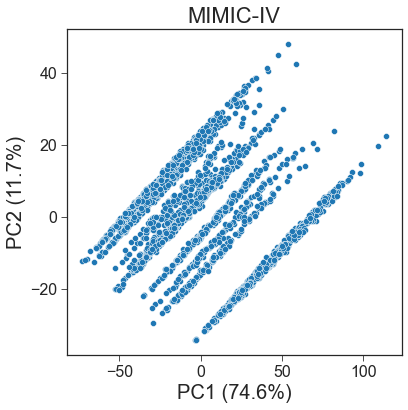

In [7]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.scatterplot(x="pc1", y="pc2", data=df_);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.title("MIMIC-IV");

# plt.savefig('../results/PCA MIMIC.jpeg', bbox_inches='tight', dpi=300)

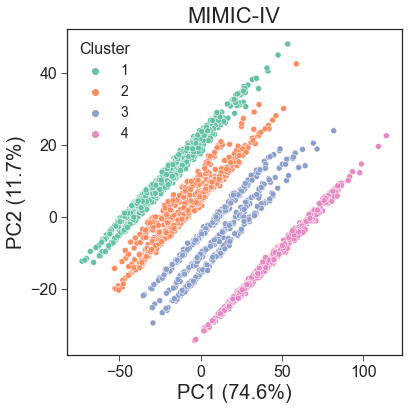

In [8]:
plt.rcParams['figure.figsize'] = (6, 6)
palette = sns.color_palette("Set2",4)

sns.scatterplot(x="pc1", y="pc2", data=df_, hue="cluster", palette=palette);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.legend(fontsize=14, title="Cluster", title_fontsize=16);
plt.title("MIMIC-IV");

# Apply to all MIMIC training data

In [9]:
df, _, _ = cluster_by_severity(df, pca, preprocessor)

Using 24 severity scores...
1    3615
2    3265
4    1678
3    1563
Name: cluster, dtype: int64


**Visualise results**

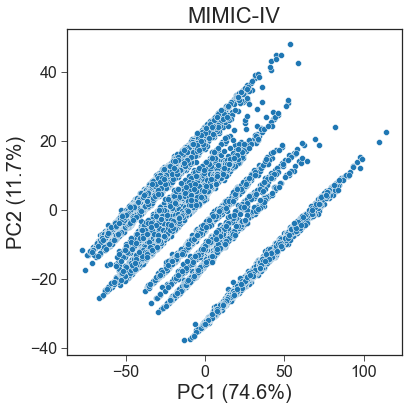

In [10]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.scatterplot(x="pc1", y="pc2", data=df);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.title("MIMIC-IV");

# plt.savefig('../results/PCA MIMIC.png', bbox_inches='tight', dpi=300)

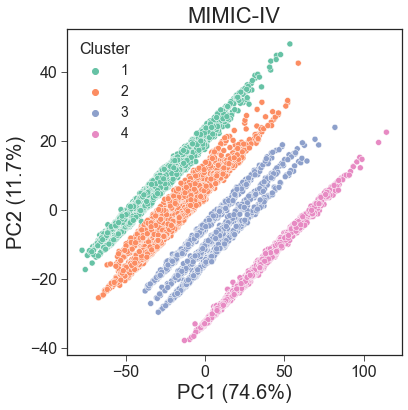

In [11]:
plt.rcParams['figure.figsize'] = (6, 6)
palette = sns.color_palette("Set2",4)

sns.scatterplot(x="pc1", y="pc2", data=df, hue="cluster", palette=palette);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.legend(fontsize=14, title="Cluster", title_fontsize=16);
plt.title("MIMIC-IV");

# plt.savefig('../results/PCA 4 clusters MIMIC.png', bbox_inches='tight', dpi=300)

**Colour by MV duration**

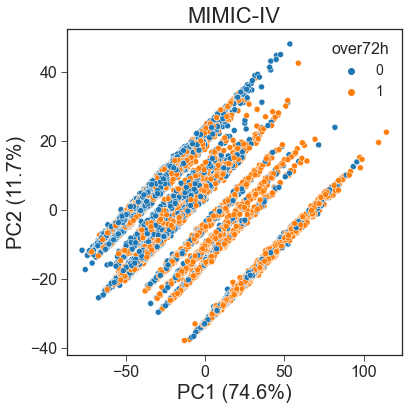

In [12]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.scatterplot(x="pc1", y="pc2", data=df, hue="over72h");
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.legend(fontsize=14, title="over72h", title_fontsize=16);
plt.title("MIMIC-IV");

# plt.savefig('../results/PCA by over72h MIMIC.png', bbox_inches='tight', dpi=300)

In [ ]:
sns.pairplot(df[["pc1", "pc2", "pc3", "over72h"]], hue="over72h");
plt.title("MIMIC-IV");
# plt.savefig('../results/PCA pairplot MIMIC.jpeg', bbox_inches='tight', dpi=300)

### Cluster characteristics

**By outcome**

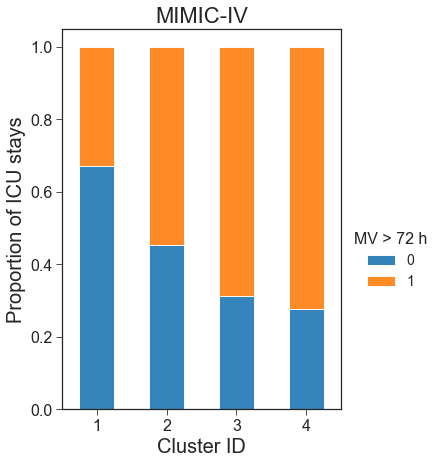

In [25]:
plt.rcParams['figure.figsize'] = (5, 7)

color = sns.color_palette()
(df.groupby("cluster").over72h.value_counts() / 
 df.groupby("cluster").over72h.size()).unstack().plot(kind="bar", 
                                                           stacked=True, 
                                                           color=color, 
                                                           alpha=0.9);
plt.xlabel("Cluster ID");
plt.ylabel("Proportion of ICU stays");
plt.xticks(rotation=0);
plt.legend(bbox_to_anchor=(1, 0.5), fontsize=14, title="MV > 72 h", title_fontsize=16);
plt.title("MIMIC-IV");

plt.savefig('../results/Prop of PMV in clusters MIMIC.png', bbox_inches='tight', dpi=300)

In [ ]:
df.groupby("cluster").duration.median()

In [ ]:
df.groupby("cluster").duration.median() / 24

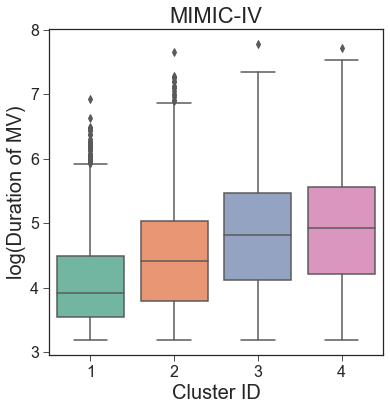

In [31]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.boxplot(y="log_duration", x="cluster", data=df, palette=palette);
plt.xlabel("Cluster ID");
plt.ylabel("log(Duration of MV)");
plt.title("MIMIC-IV");

# x_start, x_end, signif = stats.mannwhitneytest(df, "cluster", "log_duration", "two-sided", transform=None)
# stats.stat_annot(df, "cluster", "log_duration", x_start, x_end, signif, [3, 8.7], kind='boxplot')

plt.savefig('../results/MV duration in clusters boxplot MIMIC.png', bbox_inches='tight', dpi=300)

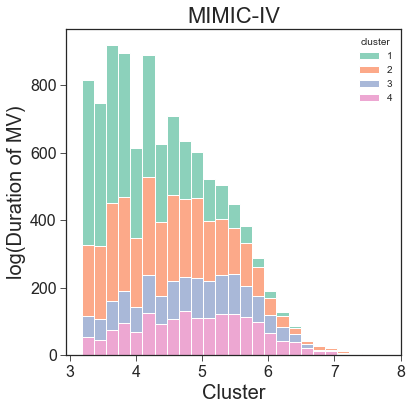

In [27]:
plt.rcParams['figure.figsize'] = (6, 6)
sns.histplot(x="log_duration", hue="cluster", data=df, bins=25, palette=palette, multiple="stack");
plt.xlabel("Cluster");
plt.ylabel("log(Duration of MV)");
plt.title("MIMIC-IV");

# plt.savefig('../results/MV duration in clusters hist MIMIC.png', bbox_inches='tight', dpi=300)

**By severity scores**

In [ ]:
df[severity_scores].corrwith(df.cluster, method="kendall").abs().sort_values(ascending=False).round(2)

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.histplot(x="gcs_score", hue="cluster", data=df, bins=25, palette=palette, multiple="stack", legend=False);
plt.xlabel("GCS score");
plt.title("MIMIC-IV");

plt.savefig('../results/GCS in clusters MIMIC.png', bbox_inches='tight', dpi=300)

In [ ]:
sns.boxplot(y="cns", x="cluster", data=df, palette=palette);

In [ ]:
df.groupby('cluster').cns.median()

In [ ]:
df.cns.min(), df.cns.max()

In [ ]:
sns.histplot(x="apsiii", hue="cluster", data=df, bins=25, palette=palette, multiple="stack");
plt.xlabel("APSIII");
plt.title("MIMIC-IV");
plt.legend();
plt.savefig('../results/APSIII in clusters MIMIC hist.png', bbox_inches='tight', dpi=300)

In [ ]:
sns.boxplot(y="apsiii", x="cluster", data=df, palette=palette, showfliers=True);
plt.xlabel("Cluster ID");
plt.ylabel("APSIII");
plt.title("MIMIC-IV");

plt.savefig('../results/APSIII in clusters MIMIC.png', bbox_inches='tight', dpi=300)

In [ ]:
sns.histplot(x="SOFA", hue="cluster", data=df, bins=24, palette=palette, multiple="stack");
plt.xlabel("SOFA");
plt.title("MIMIC-IV");
plt.legend();
plt.savefig('../results/SOFA in clusters MIMIC hist.png', bbox_inches='tight', dpi=300)

In [ ]:
sns.boxplot(y="SOFA", x="cluster", data=df, palette=palette, showfliers=True);
plt.xlabel("Cluster");
plt.ylabel("SOFA");
plt.title("MIMIC-IV");

plt.savefig('../results/SOFA in clusters MIMIC.png', bbox_inches='tight', dpi=300)

**Other characteristics**

In [ ]:
features = [col for col in df.columns if col not in severity_scores][3:-5]
df[features].corrwith(df.cluster, method="kendall").abs().sort_values(ascending=False).head(10)

# Validate on eICU data

In [13]:
df_eicu = pd.read_csv("../data/eicu-ft46.csv")
print(df_eicu.shape)
df_eicu.head()

(21185, 56)


,stay_id,starttime,endtime,duration,over72h,ph_max,spo2_min,heart_rate_min,heart_rate_max,resp_rate_min,...,coagulation,liver,cardiovascular,cns,renal,hospitalid,numbedscategory,region,teachingstatus,log_duration
0,2127890,1853,4506,44.217,0,NaN,89.0,107.0,196.0,16.0,...,4,2,1,0,2,307,L,South,False,3.789109
1,2519150,95,4175,68.000,0,NaN,88.0,96.0,116.0,13.0,...,1,0,1,1,1,338,XL,Midwest,False,4.219508
2,919705,3012,5367,39.250,0,7.51,85.0,58.0,73.0,15.0,...,0,0,1,1,1,146,L,West,False,3.669951
3,1554681,44,1724,28.000,0,7.40,91.0,87.0,113.0,0.0,...,0,2,1,0,0,248,M,Midwest,False,3.332205
4,260998,89,1937,30.800,0,7.25,75.0,109.0,121.0,28.0,...,3,2,4,2,4,79,XL,Midwest,False,3.427515


In [15]:
df_eicu, _, _ = cluster_by_severity(df_eicu, pca, preprocessor)

Using 24 severity scores...
2    7946
1    5973
4    3700
3    3566
Name: cluster, dtype: int64


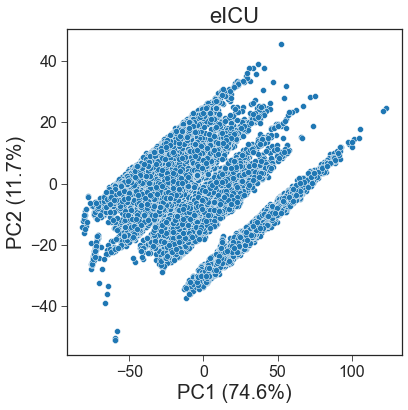

In [17]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.scatterplot(x="pc1", y="pc2", data=df_eicu);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.title("eICU");

plt.savefig('../results/PCA eICU.png', bbox_inches='tight', dpi=300)

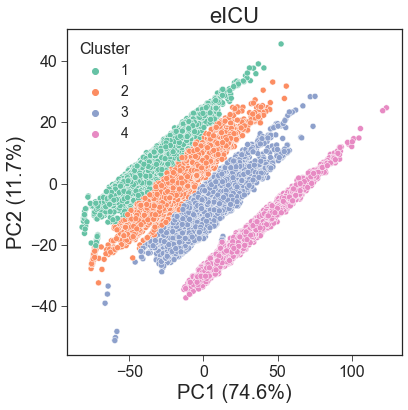

In [18]:
sns.scatterplot(x="pc1", y="pc2", data=df_eicu, hue="cluster", palette=sns.color_palette("Set2",4));
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.legend(fontsize=14, title="Cluster", title_fontsize=16);
plt.title("eICU");

plt.savefig('../results/PCA 4 clusters eICU.png', bbox_inches='tight', dpi=300)

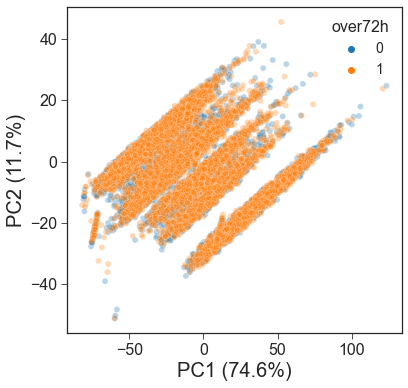

In [19]:
sns.scatterplot(x="pc1", y="pc2", data=df_eicu, hue="over72h", alpha=0.3);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.legend(fontsize=14, title="over72h", title_fontsize=16);

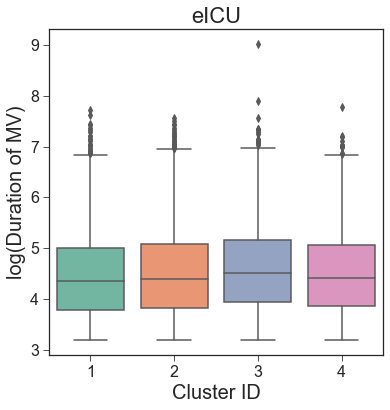

In [30]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.boxplot(y="log_duration", x="cluster", data=df_eicu, palette=palette);
plt.xlabel("Cluster ID");
plt.ylabel("log(Duration of MV)");
plt.title("eICU");

# x_start, x_end, signif = stats.mannwhitneytest(df_eicu, "cluster", "log_duration", "two-sided", transform=None)
# stats.stat_annot(df_eicu, "cluster", "log_duration", x_start, x_end, signif, [3, 8.7], kind='boxplot')

plt.savefig('../results/MV duration in clusters boxplot eICU.png', bbox_inches='tight', dpi=300)

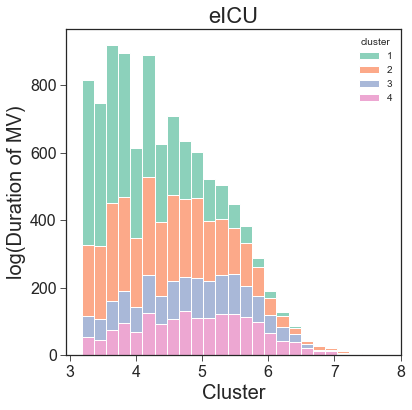

In [24]:
sns.histplot(x="log_duration", hue="cluster", data=df, bins=25, palette=palette, multiple="stack");
plt.xlabel("Cluster");
plt.ylabel("log(Duration of MV)");
plt.title("eICU");

# plt.savefig('../results/MV duration in clusters hist eICU.jpeg', bbox_inches='tight', dpi=300)

In [32]:
hospid = df_eicu.hospitalid.value_counts().head(3).index

In [38]:
def plot_pmv_proportion(df, save=False, filename =""):
    plt.rcParams['figure.figsize'] = (5, 7)
    color = sns.color_palette()
    (df.groupby("cluster").over72h.value_counts() / 
     df.groupby("cluster").over72h.size()).unstack().plot(kind="bar", 
                                                               stacked=True, 
                                                               color=color, 
                                                               alpha=0.9);
    plt.xlabel("Cluster");
    plt.xticks(rotation=0);
    plt.ylabel("Proportion of ICU stays");
    plt.legend(bbox_to_anchor=(1, 0.5), fontsize=14, title="MV > 72 h", title_fontsize=16);
    if save:
        plt.title("eICU " + filename)
        plt.savefig('../results/Prop of PMV in clusters eICU ' + filename +' .png', bbox_inches='tight', dpi=300)

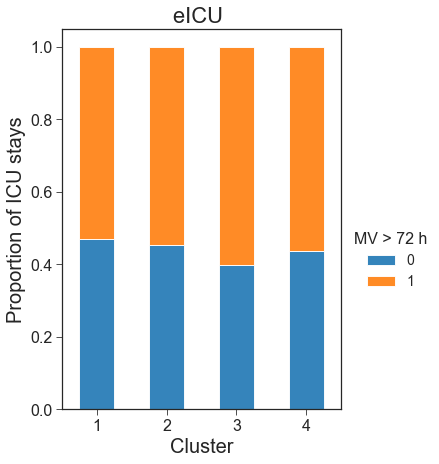

In [39]:
plot_pmv_proportion(df_eicu, save=True)

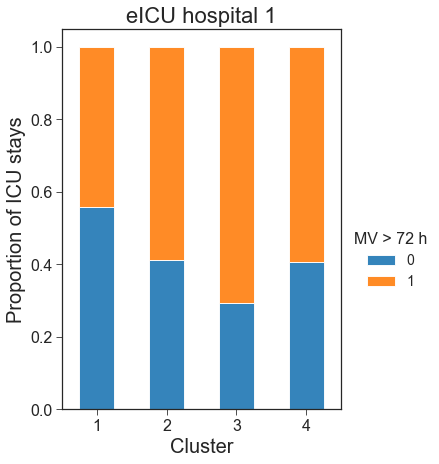

In [43]:
plot_pmv_proportion(df_eicu[df_eicu.hospitalid==hospid[0]], save=True, filename="hospital 1")

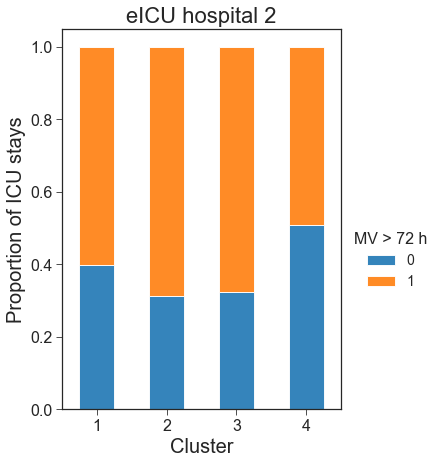

In [44]:
plot_pmv_proportion(df_eicu[df_eicu.hospitalid==hospid[1]], save=True, filename="hospital 2")

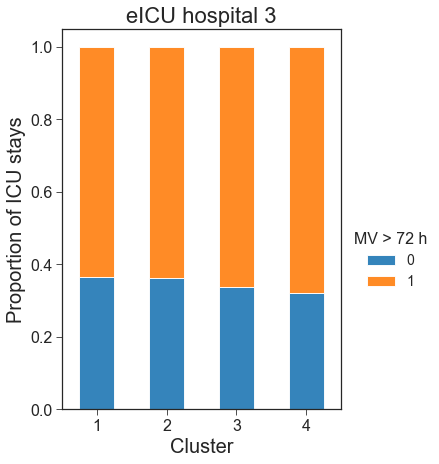

In [45]:
plot_pmv_proportion(df_eicu[df_eicu.hospitalid==hospid[2]], save=True, filename="hospital 3")

In [ ]:
plot_pmv_proportion(df_eicu[df_eicu.numbedscategory=="XL"], save=True, filename="XL")

In [ ]:
plot_pmv_proportion(df_eicu[df_eicu.numbedscategory=="L"], save=True, filename="L")

In [ ]:
plot_pmv_proportion(df_eicu[df_eicu.numbedscategory=="M"], save=True, filename="M")

In [ ]:
plot_pmv_proportion(df_eicu[df_eicu.numbedscategory=="S"], save=True, filename="S")

**By severity scores**

In [ ]:
df_eicu[severity_scores].corrwith(df_eicu.cluster, method="kendall").abs().sort_values(ascending=False)

In [ ]:
sns.histplot(x="gcs_score", hue="cluster", data=df_eicu, bins=25, palette=palette, multiple="stack", legend=False);
plt.xlabel("GCS score");
plt.title("eICU");

plt.savefig('../results/GCS in clusters eICU.jpeg', bbox_inches='tight', dpi=300)

In [ ]:
sns.boxplot(y="cns", x="cluster", data=df_eicu, palette=palette);

In [ ]:
df_eicu.groupby('cluster').cns.unique()

In [ ]:
sns.histplot(x="apsiii", hue="cluster", data=df_eicu, bins=25, palette=palette, multiple="stack");

In [ ]:
sns.boxplot(y="apsiii", x="cluster", data=df_eicu, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("APSIII");
plt.title("eICU");

plt.savefig('../results/APSIII in clusters eICU.jpeg', bbox_inches='tight', dpi=300)

In [ ]:
sns.histplot(x="SOFA", hue="cluster", data=df_eicu, bins=24, palette=palette, multiple="stack");

In [ ]:
sns.boxplot(y="SOFA", x="cluster", data=df_eicu, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("APSIII");
plt.title("eICU");

plt.savefig('../results/SOFA in clusters eICU.jpeg', bbox_inches='tight', dpi=300)

# Fit PCA to eICU data

In [ ]:
df_eicu = pd.read_csv("../data/eicu-ft46.csv")
print(df_eicu.shape)
df_eicu.head()

In [ ]:
df_eicu, pca = cluster_by_severity(df_eicu)

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)

sns.scatterplot(x="pc1", y="pc2", data=df_eicu);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.title("eICU");

> Same rules as above but taking PC2 with a minus!

In [ ]:
# Assign clusters
df_eicu.cluster = 4
df_eicu.loc[-df_eicu.pc2 > 0.5 * df_eicu.pc1 - 24.75, "cluster"] = 3
df_eicu.loc[-df_eicu.pc2 > 0.5 * df_eicu.pc1 - 0.5, "cluster"] = 2
df_eicu.loc[-df_eicu.pc2 > 0.5 * df_eicu.pc1 + 16, "cluster"] = 1

In [ ]:
sns.scatterplot(x="pc1", y="pc2", data=df_eicu, hue="cluster", palette=sns.color_palette("Set2",4));
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.legend(fontsize=14, title="Cluster", title_fontsize=16);
plt.title("eICU");

In [ ]:
sns.boxplot(y="log_duration", x="cluster", data=df_eicu, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("log(Duration of MV)");
plt.title("eICU");

In [ ]:
plot_pmv_proportion(df_eicu)

In [ ]:
df_eicu[severity_scores].corrwith(df_eicu.cluster, method="kendall").abs().sort_values(ascending=False)

In [ ]:
sns.histplot(x="gcs_score", hue="cluster", data=df_eicu, bins=25, palette=palette, multiple="stack", legend=False);
plt.xlabel("GCS score");
plt.title("eICU");

In [ ]:
sns.boxplot(y="cns", x="cluster", data=df_eicu, palette=palette);

In [ ]:
sns.boxplot(y="apsiii", x="cluster", data=df_eicu, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("APSIII");
plt.title("eICU");

In [ ]:
sns.boxplot(y="SOFA", x="cluster", data=df_eicu, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("SOFA");
plt.title("eICU");

# Using only scores related to respiratory diseases 

In [ ]:
df = pd.read_csv("../data/mimic-ft98.csv")
print(df.shape)
df.head()

In [ ]:
severity_scores = ['respiration', 'resp_rate_score', 'pao2_aado2_score', 'acidbase_score', 'SOFA', 'apsiii']

In [ ]:
df.dropna(axis=0, how="any", subset=severity_scores, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

In [ ]:
df, pca = cluster_by_severity(df, severity_scores=severity_scores)

In [ ]:
sns.pairplot(df[["pc1", "pc2", "pc3", "over72h"]], hue="over72h");

In [ ]:
sns.scatterplot(x="pc1", y="pc2", data=df);
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.title("MIMIC-IV");

In [ ]:
# Assign clusters
df.cluster = 3
df.loc[df.pc2 > -5.5 + 0.02 * df.pc1, "cluster"] = 2
df.loc[df.pc2 > -3 + 0.02 * df.pc1, "cluster"] = 1

In [ ]:
sns.scatterplot(x="pc1", y="pc2", data=df, hue="cluster", palette=sns.color_palette("Set2",3));
plt.xlabel("PC1 (%.1f%%)" % (pca.explained_variance_ratio_[0]*100));
plt.ylabel("PC2 (%.1f%%)" % (pca.explained_variance_ratio_[1]*100));
plt.legend(fontsize=14, title="Cluster", title_fontsize=16);
plt.title("eICU");

In [ ]:
sns.boxplot(y="log_duration", x="cluster", data=df, palette=palette);
plt.xlabel("Cluster");
plt.ylabel("log(Duration of MV)");
plt.title("eICU");

In [ ]:
df[severity_scores].corrwith(df.cluster, method="kendall").abs().sort_values(ascending=False)

In [ ]:
palette=sns.color_palette("Set2",3)
sns.histplot(x="acidbase_score", hue="cluster", data=df, bins=25, palette=palette, multiple="stack", legend=False);
plt.xlabel("Acid base score");
plt.title("eICU");

In [ ]:
sns.histplot(x="pao2_aado2_score", hue="cluster", data=df, bins=25, palette=palette, multiple="stack", legend=False);
plt.xlabel("PaO2 aadO2 score");
plt.title("eICU");